In [1]:
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
import random
import dotenv
import omegaconf
import hydra
import logging
import wandb
from datetime import date
import dotenv
import os
import pathlib
from typing import Dict, Any
from copy import deepcopy

from utils_eval import get_num_allzero_filters, get_num_allzero_fanout, get_num_allzero_kernels, get_num_kernels

from rigl_torch.models import ModelFactory
from rigl_torch.rigl_scheduler import RigLScheduler
from rigl_torch.rigl_constant_fan import RigLConstFanScheduler
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import (
    get_optimizer,
    get_lr_scheduler,
)
from rigl_torch.utils.checkpoint import Checkpoint
from rigl_torch.utils.rigl_utils import get_T_end, get_fan_in_after_ablation, get_conv_idx_from_flat_idx
from hydra import initialize, compose



In [2]:
with initialize("../configs", version_base="1.2.0"):
    cfg = compose(
        "config.yaml",
        overrides=[
            "dataset=cifar10",
            "compute.distributed=False",
            "model=resnet18"
            ])
dotenv.load_dotenv("../.env")
os.environ["IMAGE_NET_PATH"]
print(cfg.model.name)


resnet18


In [3]:
run_ids= ["us1p7psr", "ma4j6ft9", "f75f6a5m"]
# ['20230112_8yltfx1b', '20230112_d17iii70']
# ["20230112_2jjmdzam", "20230112_37my33se", "20230112_4d3flaxi", "20230112_f75f6a5m", "20230112_tkcz3emd"]
#run_id = "us1p7psr" # us1p7psr (no dyn ablation), 8m2ytv3b (0.01), ek5wjcyn (0.1), ma4j6ft9 (0.3), f75f6a5m (0.5)

rank=0
ckpt_path="/Users/annago/Desktop/current_projects/work_w_UCalgary/checkpointsA"
NumZeroFilters={}
NumZeroFanOut={}
zkn={}
zkf={}
sparsity={}
masks={}

for run_id in run_ids:
    checkpoint = Checkpoint.load_last_checkpoint(run_id=run_id, parent_dir = ckpt_path)
    #checkpoint=None
    if checkpoint is not None:
        run_id = checkpoint.run_id
        optimizer_state = checkpoint.optimizer
        scheduler_state = checkpoint.scheduler
        pruner_state = checkpoint.pruner
        model_state = checkpoint.model
        cfg = checkpoint.cfg
    else:
        run_id, optimizer_state, scheduler_state, pruner_state, model_state = (
            None,
            None,
            None,
            None,
            None,
        )


        # cfg.compute.distributed=False
        
    pl.seed_everything(cfg.training.seed)
    use_cuda = not cfg.compute.no_cuda and torch.cuda.is_available()
    # if not use_cuda:
    #     raise SystemError("GPU has stopped responding...waiting to die!")
    #     logger.warning(
    #         "Using CPU! Verify cfg.compute.no_cuda and "
    #         "torch.cuda.is_available() are properly set if this is unexpected"
    #     )


    if cfg.compute.distributed and use_cuda:
        device = torch.device(f"cuda:{rank}")
    else:
        print(f"loading to device rank: {rank}")
        device = torch.device(f"cuda:{rank}")
    if not use_cuda:
        device = torch.device("cuda" if use_cuda else "cpu")
    # train_loader, test_loader = get_dataloaders(cfg)

    model = ModelFactory.load_model(
        model=cfg.model.name, dataset=cfg.dataset.name
    )
    model.to(device)
    if cfg.compute.distributed:
        model = DistributedDataParallel(model, device_ids=[rank])
    if model_state is not None:
        try:
            model.load_state_dict(model_state)
        except RuntimeError:
            model_state = checkpoint.get_single_process_model_state_from_distributed_state()
            model.load_state_dict(model_state)
            
    optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
    scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
    pruner = None
    if cfg.rigl.dense_allocation is not None:
        T_end = get_T_end(cfg, [0 for _ in range(0,1251)])
        if cfg.rigl.const_fan_in:
            rigl_scheduler = RigLConstFanScheduler
        else:
            rigl_scheduler = RigLScheduler
        pruner = rigl_scheduler(
            model,
            optimizer,
            dense_allocation=cfg.rigl.dense_allocation,
            alpha=cfg.rigl.alpha,
            delta=cfg.rigl.delta,
            static_topo=cfg.rigl.static_topo,
            T_end=T_end,
            ignore_linear_layers=cfg.rigl.ignore_linear_layers,
            grad_accumulation_n=cfg.rigl.grad_accumulation_n,
            sparsity_distribution=cfg.rigl.sparsity_distribution,
            erk_power_scale=cfg.rigl.erk_power_scale,
            state_dict=pruner_state,
            filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
            static_ablation=cfg.rigl.static_ablation,
            dynamic_ablation=cfg.rigl.dynamic_ablation,
            min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,  # noqa
            use_sparse_init=cfg.rigl.use_sparse_initialization,
            init_method_str=cfg.rigl.init_method_str,
            use_sparse_const_fan_in_for_ablation=cfg.rigl.use_sparse_const_fan_in_for_ablation,  # noqa
        )
        
        step=0
        
        checkpoint = Checkpoint(
                    run_id=run_id,
                    cfg=cfg,
                    model=model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    pruner=pruner,
                    epoch=0,
                    step=step,
                    parent_dir=ckpt_path,
                )

    NumZeroFilters[run_id]= []
    NumZeroFanOut[run_id]= []

    for i, w in enumerate(pruner.W):
        if pruner.S[i]>0:
            num_zero_filters= get_num_allzero_filters(w)
            num_zero_fanout = get_num_allzero_fanout(w)
        else:
            num_zero_filters=0
            num_zero_fanout=0
        NumZeroFilters[run_id].append(num_zero_filters)
        NumZeroFanOut[run_id].append(num_zero_fanout)

    sparsity[run_id]=pruner.S

    masks[run_id]= pruner.backward_masks

    zkf[run_id]= []
    zkn[run_id]= []

    for i, w in enumerate(pruner.W):
        if pruner.S[i]>0:
            zero_kernel_fract= get_num_allzero_kernels(w)/get_num_kernels(w)
            num_allzero_kernels= get_num_allzero_kernels(w)
        else:
            zero_kernel_fract=0
            num_allzero_kernels=0
        zkf[run_id].append(zero_kernel_fract)
        zkn[run_id].append(num_allzero_kernels)


    


INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /Users/annago/Desktop/current_projects/work_w_UCalgary/checkpointsA/20221208_us1p7psr/checkpoint.pt.tar...
Global seed set to 42
INFO:/Users/annago/Desktop/current_projects/work_w_UCalgary/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x16c9feca0> with args: () and kwargs: {}


loading to device rank: 0


INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /Users/annago/Desktop/current_projects/work_w_UCalgary/checkpointsA/20230111_ma4j6ft9/checkpoint.pt.tar...
Global seed set to 6037
INFO:/Users/annago/Desktop/current_projects/work_w_UCalgary/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x16c9feca0> with args: () and kwargs: {}


loading to device rank: 0


INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /Users/annago/Desktop/current_projects/work_w_UCalgary/checkpointsA/20230112_f75f6a5m/checkpoint.pt.tar...
Global seed set to 42
INFO:/Users/annago/Desktop/current_projects/work_w_UCalgary/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x16c9feca0> with args: () and kwargs: {}


loading to device rank: 0


In [ ]:
num_layers= len(pruner.W)
layer_inds=[]

for layer_idx in range(num_layers):
    if pruner.W[layer_idx].shape[-1]==3:
        layer_inds.append(layer_idx)
        

# check for zero fan-in and fan-out

num_layers= len(pruner.W)
num_disconnected_neurons={}

for l in range(len(layer_inds)-1):
    
    w1= pruner.W[layer_inds[l]]
    w2= pruner.W[layer_inds[l+1]]

    num_neurons= w1.shape[0]
    count=0
    for neuron_idx in range(num_neurons):
        if w2[:,neuron_idx,:,:].any()==False and w1[neuron_idx,:,:,:].any()==False:
            count+=1
    
    num_disconnected_neurons[layer_inds[l]]=count


In [ ]:
num_disconnected_neurons

In [ ]:
run_id= "f75f6a5m"

num_layers= len(masks[run_id])
for layer_ind in range(num_layers):
    if masks[run_id][layer_ind] is not None:
        s= masks[run_id][layer_ind].shape
    else:
        s='None'
    print(layer_ind, s)

In [4]:
MaskNumZeroFilters={}
MaskNumZeroFanOut={}

for run_id in run_ids:
    MaskNumZeroFilters[run_id]= []
    MaskNumZeroFanOut[run_id]= []
    for i, w in enumerate(masks[run_id]):
        if sparsity[run_id][i]>0:
            num_zero_filters= get_num_allzero_filters(w)
            num_zero_fanout = get_num_allzero_fanout(w)
        else:
            num_zero_filters=0
            num_zero_fanout=0
        MaskNumZeroFilters[run_id].append(num_zero_filters)
        MaskNumZeroFanOut[run_id].append(num_zero_fanout)

In [ ]:
# masks= checkpoint.pruner.backward_masks
# num_layers= len(masks)
# for layer_ind in range(num_layers):
#     if masks[layer_ind] is not None:
#         s= masks[layer_ind].shape
#     else:
#         s='None'
#     print(layer_ind, s)

In [ ]:
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [ ]:
flatM= get_children(M)

j=0
for i, layer in enumerate(flatM):
    if isinstance(layer, (torch.nn.Conv2d,torch.nn.AvgPool2d)):
        print(j, layer, "   ", masks[j].shape)
        j+=1

In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plot_savedir = '/Users/annago/Desktop/'
cmap = matplotlib.cm.get_cmap('gnuplot2') # rainbow

x=3.5
title_font_size=6*x
label_font_size=5.5*x
tick_font_size=5*x
legend_font_size=22*x/6
legend_title_font_size=22*x/6

# ==== plot styling
plotparams = {'savefig.dpi': 300,
              'text.usetex': True,
              'font.family': 'serif',
              'legend.fontsize': legend_font_size,
              'legend.title_fontsize': legend_title_font_size,
              'axes.labelsize': label_font_size,
              'axes.titlesize': title_font_size,
              'xtick.labelsize': tick_font_size,
              'ytick.labelsize': tick_font_size,
              'axes.grid': True,
              'axes.grid.axis': 'both',
              'axes.grid.which': 'both',
              'grid.alpha': 0.5,
              'grid.color': '#b0b0b0',
              'grid.linestyle': '-',
              'grid.linewidth': 0.8}
plt.style.use(plotparams)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


def label_bars(ax, bars, text_format, **kwargs):
    """
    Attaches a label on every bar of a regular or horizontal bar chart
    """
    ys = [bar.get_y() for bar in bars]
    y_is_constant = all(y == ys[0] for y in ys)  # -> regular bar chart, since all bars start on the same y level (0)

    if y_is_constant:
        _label_bar(ax, bars, text_format, **kwargs)
    else:
        _label_barh(ax, bars, text_format, **kwargs)


def _label_bar(ax, bars, text_format, **kwargs):
    """
    Attach a text label to each bar displaying its y value
    """
    max_y_value = ax.get_ylim()[1]
    inside_distance = max_y_value * 0.05
    outside_distance = max_y_value * 0.01

    for bar in bars:
        text = text_format.format(bar.get_height())
        text_x = bar.get_x() + bar.get_width() / 2

        is_inside = bar.get_height() >= max_y_value * 0.15
        if is_inside:
            color = "white"
            text_y = bar.get_height() - inside_distance
        else:
            color = "black"
            text_y = bar.get_height() + outside_distance

        ax.text(text_x, text_y, text, ha='center', va='bottom', color=color, **kwargs)


def _label_barh(ax, bars, text_format, **kwargs):
    """
    Attach a text label to each bar displaying its y value
    Note: hacky ad-hoc solution to adjust text position inside/outside the bars.
    """
    max_x_value = ax.get_xlim()[1]
    distance = max_x_value * 0.15

    for bar in bars:
        text = text_format.format(bar.get_width())
        
        bwidth = bar.get_width()
        if bwidth<distance: 
            text_x= bwidth + distance/4
        else: 
            text_x= bwidth + distance/4
            
        text_y= bar.get_y() + bar.get_height() / 2

        if bwidth>0: # do not print zero values
            if bwidth==max_x_value:
                ax.text(text_x-70, text_y, text, va='center', **kwargs)
            else:
                ax.text(text_x, text_y, text, va='center', **kwargs)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from collections import MutableMapping
def flatten(d, parent_key='', sep='_'):
	items = []
	for k, v in d.items():
		new_key = parent_key + sep + k if parent_key else k
		if isinstance(v, MutableMapping):
			items.extend(flatten(v, new_key, sep=sep).items())
		else:
			items.append((new_key, v))
	return dict(items)
	
def get_tensor_dims(model, ltypes):
	""" Makes dict tensor_dims containing the dimensions of each layer tensor. """
	tensor_dims= {}
	fill_tensor_dims(model, ltypes, tensor_dims)
	tensor_dims= flatten(tensor_dims)
	return tensor_dims


def fill_tensor_dims(model, ltypes, tensor_dims):
	""" Fills the dict tensor_dims with the dims of each layer of type specified in ltypes 
	in the given model. """   
	for lname, child in model.named_children():
		ltype = child._get_name()

		if ltype in ltypes:
			tensor_dims[lname] = list(child.weight.shape)
		else:
			tensor_dims[lname] = {}
			fill_tensor_dims(child, ltypes, tensor_dims[lname])

/var/folders/n4/8l3wyv69321f4xp28b53dc240000gn/T/ipykernel_60284/136258565.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import MutableMapping


In [6]:
ltypes=['Linear', 'Conv2d']
tdims= get_tensor_dims(model, ltypes)

In [ ]:
print("orig.width - abl.neurons = remaining width")
for i in range(len(NumZeroFilters[run_id])-1):
    num_out_dense= pruner.W[i].shape[0]
    num_out_gone= NumZeroFilters[run_id][i]
    num_out_left= pruner.W[i].shape[0]-NumZeroFilters[run_id][i]
    print(f"{num_out_dense} - {num_out_gone} = {num_out_left} ({100*num_out_left/num_out_dense:.1f} %)")


In [ ]:
run_ids

In [40]:
la= {'us1p7psr': 'no abl.', '8m2ytv3b': 'abl.t.=0.01', 'ek5wjcyn': 'abl.t.=0.1', 'ma4j6ft9': 'abl.t.=30%', 'f75f6a5m': 'abl.t.=50%'}
ma= {'us1p7psr': 'x', 
'8m2ytv3b': 'o', 
'ek5wjcyn': 'o', 
'f75f6a5m': 'o'}
ma_size=6

In [ ]:
save_fig= True
fig_savename= 'combined'

fig, axs = plt.subplots(1,4, figsize=(12,2.5))


ax=axs[0]
for run_id in run_ids:
    v= sparsity[run_id]
    ax.plot(v[:-1], label=la[run_id], linestyle='', marker=ma[run_id], markersize=ma_size, markerfacecolor='none')

ax.legend()
ax.set_xlabel('layer index')
ax.set_ylabel('sparsity')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax=axs[1]
for run_id in run_ids:
    v= zkf[run_id]
    ax.plot(v[:-1], label=la[run_id], linestyle='', marker=ma[run_id], markersize=ma_size, markerfacecolor='none')

ax.set_xlabel('layer index')
ax.set_ylabel('fraction all-zero kernels')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


ax=axs[2]
for run_id in run_ids:
    v= NumZeroFilters[run_id]
    p= [v[i]/pruner.W[i].shape[0] for i in range(len(v))]
    ax.plot(p[:-1], label=la[run_id], linestyle='', marker=ma[run_id], markersize=ma_size, markerfacecolor='none')

ax.set_xlabel('layer index')
ax.set_ylabel('fraction all-zero neurons')


ax=axs[3]
for run_id in run_ids:
    v= NumZeroFanOut[run_id]
    p= [v[i]/pruner.W[i].shape[1] for i in range(len(v))]
    ax.plot(p[:-1], label=la[run_id], linestyle='', marker=ma[run_id], markersize=ma_size, markerfacecolor='none')

ax.set_xlabel('layer index')
ax.set_ylabel('fraction all-zero fan-out')


plt.tight_layout()
plt.show()
if save_fig:
    fig.savefig(plot_savedir+fig_savename+'.png', format='png', bbox_inches='tight')

In [ ]:
save_fig= True
fig_savename= 'zero_kernel_fract'

fig, ax = plt.subplots(1,1, figsize=(6,4))

for run_id in run_ids:
    v= zkf[run_id]
    ax.plot(v, label=la[run_id], linestyle='', marker=ma[run_id], markersize=ma_size, markerfacecolor='none')

ax.legend()
ax.set_xlabel('layer index')
ax.set_ylabel('fraction all-zero kernels')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()
if save_fig:
    fig.savefig(plot_savedir+fig_savename+'.png', format='png', bbox_inches='tight')


In [ ]:
save_fig= True
fig_savename= 'zero_neurons_fract'

fig, ax = plt.subplots(1,1, figsize=(6,4))

for run_id in run_ids:
    v= NumZeroFilters[run_id]
    p= [v[i]/pruner.W[i].shape[0] for i in range(len(v))]
    ax.plot(p, label=la[run_id], linestyle='', marker=ma[run_id], markersize=ma_size, markerfacecolor='none')

ax.legend()
ax.set_xlabel('layer index')
ax.set_ylabel('fraction all-zero neurons')

plt.show()
if save_fig:
    fig.savefig(plot_savedir+fig_savename+'.png', format='png', bbox_inches='tight')

In [ ]:
save_fig= True
fig_savename= 'sparsity'

fig, ax = plt.subplots(1,1, figsize=(6,4))

for run_id in run_ids:
    v= sparsity[run_id]
    ax.plot(v, label=la[run_id], linestyle='', marker=ma[run_id], markersize=ma_size, markerfacecolor='none')

ax.legend()
ax.set_xlabel('layer index')
ax.set_ylabel('sparsity')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()
if save_fig:
    fig.savefig(plot_savedir+fig_savename+'.png', format='png', bbox_inches='tight')

In [49]:
## Style sheet: 
style = """
# Figure properties
figure.figsize: 10, 6 # figure size in inches

# Font properties
font.size: 16 # Size of the font
font.family: sans-serif # Type of Font
font.sans-serif : "DejaVu Sans"


# Axes properties
axes.linewidth: 2  # edge linewidth
axes.labelpad: 8   # space between label and axis
axes.prop_cycle: cycler(color=['00a5bb','f79141','499585', 'd81e52', '6cb2c5' , '6c77c5', 'c5ba6c', '56ce93', 'd88fBf', 'ffd505']) # color cycle for plot lines
axes.titlepad: 20.0    # pad between axes and title in points
axes.labelsize: 16     # Axes labels size
axes.titlesize: 20     # Plot title size
axes.labelweight: 500  # Axel Labels weight
axes.titleweight: 500  # Axel Titleweight
axes.edgecolor: 262626
axes.labelcolor: 262626
axes.titlecolor: 262626

# Tick properties
# x-axis
xtick.direction: inout # direction: in, out, or inout
xtick.major.size: 0 # major tick size in points
xtick.major.width: 0 # major tick width in points
xtick.minor.size: 0 # minor tick size in points
xtick.minor.width: 0 # minor tick width in points
xtick.major.pad : 10
xtick.minor.pad: 10
xtick.labelsize : 16

# y-axis
ytick.direction: inout # direction: in, out, or inout
ytick.major.size: 0 # major tick size in points
ytick.major.width: 0 # major tick width in points
ytick.minor.size: 0 # minor tick size in points
ytick.minor.width: 0 # minor tick width in points
ytick.major.pad : 10
ytick.minor.pad: 10
ytick.labelsize : 16

# Line properties
lines.linewidth: 3.5

# Legend properties
legend.framealpha: 0.8  # opacity of legend frame
legend.frameon: False   # whether or not to draw a frame around legend
legend.fontsize: 14     # Font size of the legend
legend.borderpad : 0
#legend.borderaxespad: 1.5

#Edge Color properties
#patch.force_edgecolor: True #Edge color for the bars
"""
with open("plt_plot_style.mplstyle", "w") as handle:
  handle.write(style)

plt.style.use("./plt_plot_style.mplstyle")

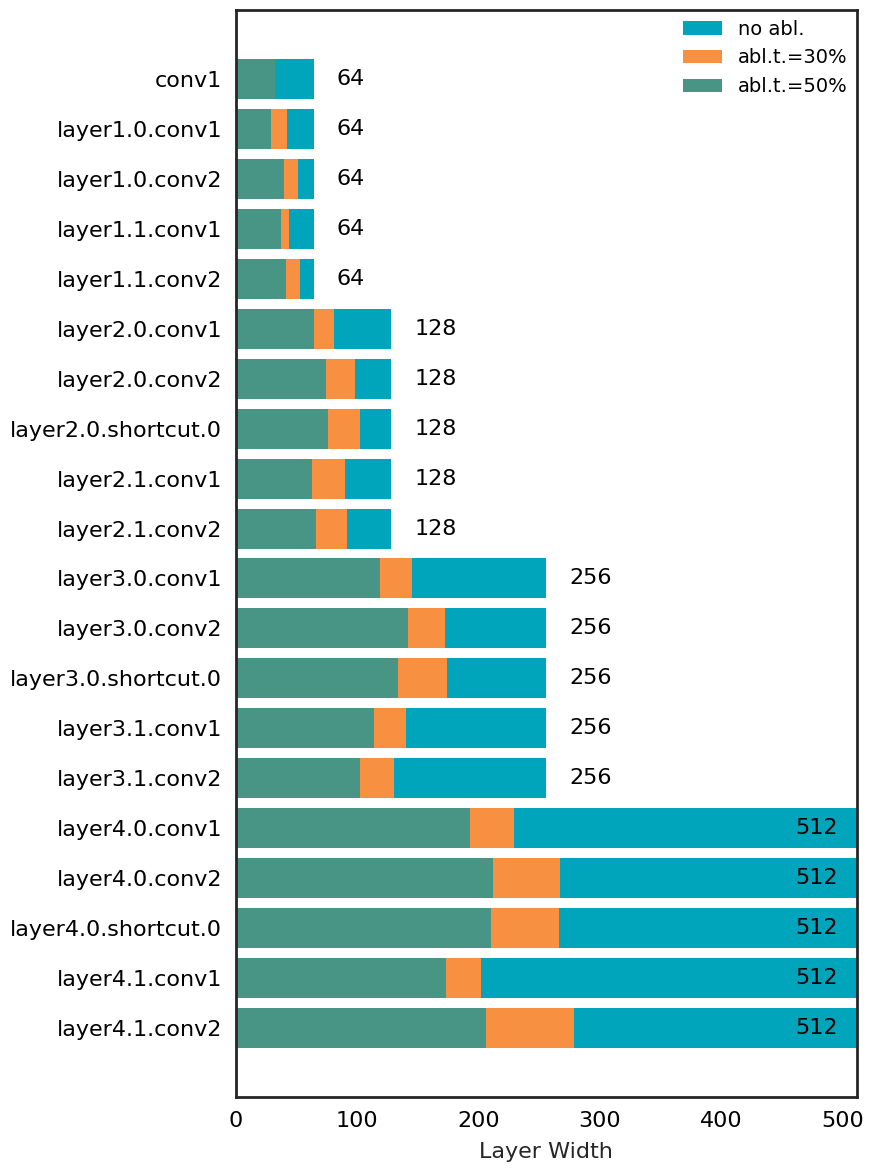

In [50]:
# HORIZONTAL BAR PLOT
save_fig= True
fig_savename= "resnet18_width"
fig, ax = plt.subplots(1,1,figsize=(9,12))
#plt.suptitle(f'Per-layer sparsity distribution in {args.resnet_type} with base width {args.noc1_base}', fontsize=title_font_size)


lnames= list(tdims.keys())
lnames.remove('linear')
y_pos = np.arange(len(lnames))

x_val = [pruner.W[i].shape[0] for i in range(len(pruner.W)-1)]
#x_val = np.zeros(len(pruner.S))
error = None

bars= ax.barh(y_pos, x_val, xerr=error, align='center', alpha=1, color='white')# , label='orig.width')
ax.set_yticks(y_pos)
ax.set_yticklabels([l.replace("_",".") for l in lnames])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Layer Width') #Width Sparsity
#ax.set_ylabel('Layer Index')
ax.set_xlim([0,512]) 
value_format= "{:.0f}"
label_bars(ax, bars, value_format)

for run_id in run_ids:
    x_val = [masks[run_id][i].shape[0]-MaskNumZeroFilters[run_id][i] for i in range(len(masks[run_id])-1)]
    #x_val = [pruner.W[i].shape[0]-NumZeroFilters[run_id][i] for i in range(len(pruner.W))]
    #x_val = 100*np.array(sparsity[run_id])
    bars= ax.barh(y_pos, x_val, xerr=error, align='center', alpha=1, label=la[run_id])
    
    #label_bars(ax, bars, value_format)

plt.legend()
plt.tight_layout()
#fig.subplots_adjust(wspace=0.25)
plt.show()
if save_fig:
    fig.savefig(plot_savedir+fig_savename+'.svg', format='svg', bbox_inches='tight')

In [ ]:
x_val = [masks[run_id][i].shape[0]-MaskNumZeroFilters[run_id][i] for i in range(len(masks[run_id])-1)]

In [ ]:
lnames.remove('linear')

In [ ]:
for i in range(8):
    w= pruner.W[i]
    #r= 1-torch.count_nonzero(w)/w.numel()
    r= 1-torch.count_nonzero(masks[i])/w.numel()
    s= pruner.S[i]
    print(f"{r.item():.4}, {s:.4}")

In [ ]:
#NumZeroFilters={}
NumZeroFilters[run_id]= []

for i, w in enumerate(pruner.W):
    if pruner.S[i]>0:
        num_zero_filters= get_num_allzero_filters(w)
    else:
        num_zero_filters=0
    NumZeroFilters[run_id].append(num_zero_filters)


In [ ]:
for k, v in zkf.items():
    print(k)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

cmap = mpl.cm.get_cmap('plasma') # rainbow

x=2.6
title_font_size=5.5*x
label_font_size=5.5*x
tick_font_size=5*x
legend_font_size=23*x/6
legend_title_font_size=22*x/6

#==== plot styling
plotparams = {
              'legend.fontsize': legend_font_size,
              'legend.title_fontsize': legend_title_font_size,
              'axes.labelsize': label_font_size,
              'axes.titlesize': title_font_size,
              'xtick.labelsize': tick_font_size,
              'ytick.labelsize': tick_font_size
}
plt.style.use(plotparams)


In [ ]:
    
import matplotlib.pyplot as plt
%matplotlib inline
lrs=[]
for _ in list(range(1,149)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

plt.plot(lrs)

In [ ]:
scheduler_state_dict, optimizer_state_dict = checkpoint.get_state()["scheduler"], checkpoint.get_state()["optimizer"]

In [ ]:
new_optim = get_optimizer(cfg, model, optimizer_state_dict)
ckp_scheduler= get_lr_scheduler(cfg, new_optim, state_dict=scheduler_state_dict)

In [ ]:
ckp_scheduler.state_dict()

In [ ]:
    
import matplotlib.pyplot as plt
%matplotlib inline
lrs=[]
for _ in list(range(149,501)):
    ckp_scheduler.step()
    lrs.append(ckp_scheduler.get_last_lr())

plt.plot(lrs)

In [ ]:
ckp_scheduler.__dict__

In [ ]:
import matplotlib.pyplot as plt

lrs = []
for epoch in list(range(1,150)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())
print(lrs)
plt.plot(lrs)

In [ ]:
pruner.__str__()

In [ ]:
# net = ModelFactory.load_model("wide_resnet22", "cifar10")
model = ModelFactory.load_model("resnet50", "imagenet")
device = torch.device("cuda:0")
train_loader, test_loader = get_dataloaders(cfg)
# model = ModelFactory.load_model(
#         model=cfg.model.name, dataset=cfg.dataset.name
#     )
model.to(device)
optimizer = get_optimizer(cfg, model, state_dict=None)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=None)
T_end = get_T_end(cfg, train_loader)
if cfg.rigl.const_fan_in:
    rigl_scheduler = RigLConstFanScheduler
else:
    rigl_scheduler = RigLScheduler
# pruner = rigl_scheduler(
#     model,
#     optimizer,
#     dense_allocation=cfg.rigl.dense_allocation,
#     alpha=cfg.rigl.alpha,
#     delta=cfg.rigl.delta,
#     static_topo=cfg.rigl.static_topo,
#     T_end=T_end,
#     ignore_linear_layers=False,
#     grad_accumulation_n=cfg.rigl.grad_accumulation_n,
#     sparsity_distribution=cfg.rigl.sparsity_distribution,
#     erk_power_scale=cfg.rigl.erk_power_scale,
#     state_dict=None,
#     filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
#     static_ablation=cfg.rigl.static_ablation,
#     dynamic_ablation=cfg.rigl.dynamic_ablation,
#     min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,
#     )

In [ ]:
pruner(
    
)